<a href="https://colab.research.google.com/github/AnthonyCampos123/SURP-Neural-Network-Model-Distillation-and-Pruning-for-Pattern-Recognition-and-Predictions/blob/main/PyTorch_Convolutional_Neural_Network_SURP%2Cipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms # MNIST dataset
from torchvision.utils import make_grid

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms # MNIST dataset
from torchvision.utils import make_grid

# accuracy by class (table)
# 1-9
# table, 2 columns (class, accuracy)

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# convolutional neural network(CNN)

# (1) input image
# (2) featured maps (determines borders)
# (3) pooled featured maps
# (4) featured maps
# (5) pooled featured maps
# (6) flatten layer
# (7) neural network (fully connected)
# (8) output

# convolution (find outline of image)
# image filter/kernel - creates blur/shade of gray on border
# is applied pixel by pixel and multiplication is performed (convolution)
# stride move matrix (with weights) across
# reducing convolution layer down sampling / sub sampling
# ex. max pooling, average pooling

# goal is to learn what the weights should be
# input - > image patch -> kernel (filter) -> output
# in a convolutional neural network, neurons are locally connected
# more data in the image, neurans are not fully connected
# convulational layer
# color images will require 3 dimensional tensors (rgb)

#MNIST dataset
# background is a '0'
# image is a different shade and a '1'
# edges are less than '1'

# convert MNIST image files into 4-d tensor (number of images, height, width, color channel)
transform = transforms.ToTensor()

# train Data
train_data = datasets.MNIST(root='/cnn_data_1', train=True, download=True, transform=transform) # root = save locally

# test data
test_data = datasets.MNIST(root='/cnn_data_1', train=False, download=True, transform=transform)

#train_data
#test_data

# batch size of 10 for images
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

# define CNN model
# 2 convolutional layers
conv1 = nn.Conv2d(1, 6, 3, 1) # convolutional network of 2 dimensions, 6 filters, kernel size 3, stride: 1, 6 ouputs
conv2 = nn.Conv2d(6, 16, 3, 1) # 6 inputs, 16 outputs

# grab 1 MNIST record/image
for i, (X_train, y_train) in enumerate(train_data):
  break

x = X_train.view(1,1,28,28)

# perform first convolution
x = F.relu(conv1(x)) # rectified linear unit for activation function

# 1 single image, 6 are the filters, 26x26
x.shape

# pass through the pooling layer
x = F.max_pool2d(x, 2, 2) # kernal of 2, stride of 2

# after pooling: 26 / 2 = 13
# x.shape

# second convolutional layer
x = F.relu(conv2(x))

#x.shape # no padding, so lose 2 pixels outside of the image

# pooling layer
x = F.max_pool2d(x,2,2)

# x.shape # 11 / 2 = 5

# model class for convolutional network
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)

    # fully connected layer
    self.fc1 = nn.Linear(5*5*16,120) # 120 neurons
    self.fc2 = nn.Linear(120, 84) # 120 inputs
    self.fc3 = nn.Linear(84, 10) # 84 inputs

  def forward(self, X):
    # first pass
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernal and stride of 2

    # second pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernal and stride of 2

    # re-view to flatten out
    X = X.view(-1, 16*5*5) # '-1' causes variation in batch size

    # fully connected layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return X

# create an instance of the CNN model

torch.manual_seed(47)
model = ConvolutionalNetwork()
# model

# loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # smaller learning rate, longer it will take

import time
start_time = time.time()

# create variables to track network
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []
class_correct = [0 for _ in range(10)]  # 10 classes
class_total = [0 for _ in range(10)]    # 10 classes

# for loop of epochs
for i in range(epochs):
  trn_corr = 0 # train correct
  tst_corr = 0 # test correct

  # train
  for b, (X_train, y_train) in enumerate(train_loader):
    b += 1 # start batches at 1
    y_pred = model(X_train) # get predicted values from the training set, 2d not flattened
    loss = criterion(y_pred, y_train) # incorrect, compare predictions with correct in y_train

    predicted = torch.max(y_pred.data, 1)[1] # sum up correct predictions, indexed off first point
    batch_corr = (predicted == y_train).sum() # how many correct from batch, sum based on True = 1, False = 0
    trn_corr += batch_corr # track as model is trained

    # update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print out results
    if b % 600 == 0:
      print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr) # correct


  # test/validation
  with torch.no_grad(): # no gradient so weights and biases are not updated with test data
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # sum up number of correct predictions
      tst_corr += (predicted == y_test).sum() # how many correct from batch, sum based on True = 1, False = 0

      # Calculate accuracy per class
      for i in range(len(y_test)):
          label = y_test[i]
          pred = predicted[i]
          if label == pred:
              class_correct[label] += 1
          class_total[label] += 1

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)

# Calculate and print the accuracy for each class
for i in range(10):  # 10 classes
    if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        print(f'Accuracy for class {i}: {accuracy:.2f}%') # shorten to 2 decimals
    else:
        print(f'No samples for class {i}')


current_time = time.time()
total_time = current_time - start_time
print(f'Training took: {total_time/60} minutes.')


Epoch: 0 Batch: 600 Loss: 0.3329475522041321
Epoch: 0 Batch: 1200 Loss: 0.019725272431969643
Epoch: 0 Batch: 1800 Loss: 0.03747250884771347
Epoch: 0 Batch: 2400 Loss: 0.11672516912221909
Epoch: 0 Batch: 3000 Loss: 0.024873368442058563
Epoch: 0 Batch: 3600 Loss: 0.5177805423736572
Epoch: 0 Batch: 4200 Loss: 0.15901848673820496
Epoch: 0 Batch: 4800 Loss: 0.03606381267309189
Epoch: 0 Batch: 5400 Loss: 0.005262424238026142
Epoch: 0 Batch: 6000 Loss: 0.0015833990182727575
Epoch: 1 Batch: 600 Loss: 0.04298064485192299
Epoch: 1 Batch: 1200 Loss: 0.021269531920552254
Epoch: 1 Batch: 1800 Loss: 0.009933723136782646
Epoch: 1 Batch: 2400 Loss: 0.03247081860899925
Epoch: 1 Batch: 3000 Loss: 0.008966338820755482
Epoch: 1 Batch: 3600 Loss: 0.004959109239280224
Epoch: 1 Batch: 4200 Loss: 0.014899730682373047
Epoch: 1 Batch: 4800 Loss: 0.0005080188857391477
Epoch: 1 Batch: 5400 Loss: 0.0001429358235327527
Epoch: 1 Batch: 6000 Loss: 0.008406112901866436
Epoch: 2 Batch: 600 Loss: 0.01349744014441967
Epo

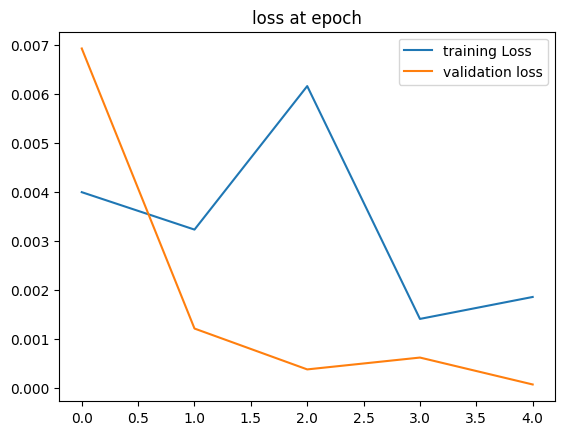

In [ ]:
# graph the loss at each epoch
train_losses = [tl.item() for tl in train_losses] # convert tensor to python list
plt.plot(train_losses, label="training Loss")
plt.plot(test_losses, label ="validation loss")
plt.title("loss at epoch")
plt.legend()

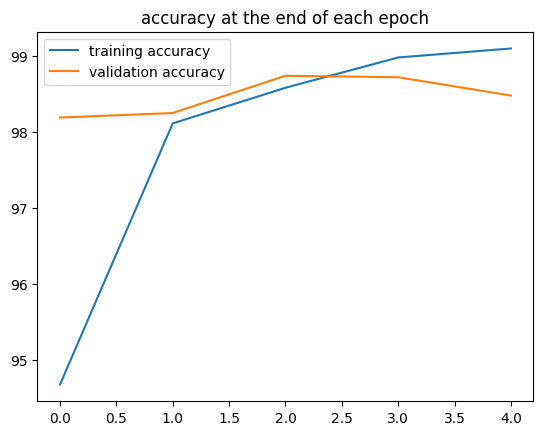

In [ ]:
# graph the accuracy at each epoch
plt.plot([t/600 for t in train_correct], label="training accuracy") # epochs are in iterations of 600
plt.plot([t/100 for t in test_correct], label="validation accuracy")
plt.title("accuracy at the end of each epoch")
plt.legend()

In [ ]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_all:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum() # get sum where predicted equals expected correct reszult

# percentage correct
correct.item()/len(test_data)*100

In [ ]:
# grab an image
test_data[4747] # tensor with an image in it, label given at the end

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [ ]:
# grab only its data (without label)
test_data[4747][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [ ]:
# reshape
test_data[4747][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

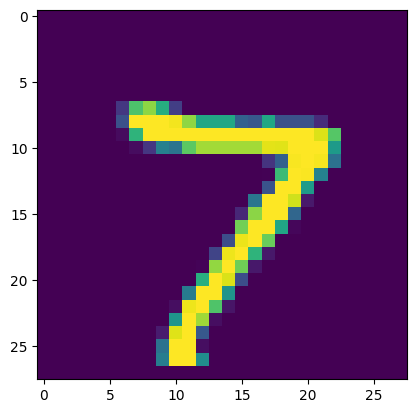

In [ ]:
# show the image
plt.imshow(test_data[4747][0].reshape(28,28))

In [ ]:
# pass image through the model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[4747][0].view(1,1,28,28)) # batch size of 1, 1 color channel, 28x28 px image

# check the new predicted/get probabilites (10 proaabilities for nums 0-9, highest proability is prediction)
new_prediction

tensor([[-18.6408,  -6.9770,  -6.8751,  -4.3638,  -5.6525,  -7.3067, -23.8857,
           8.6645,  -8.1137,  -1.6225]])

In [ ]:
# show prediction
new_prediction.argmax()

tensor(7)